<a href="https://colab.research.google.com/github/hnishi/hello-automl/blob/main/h2o_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://docs.h2o.ai/h2o/latest-stable/h2o-docs/downloading.html#install-in-python
!pip install -q requests  tabulate  "colorama>=0.3.8" future h2o

     |████████████████████████████████| 164.8 MB 37 kB/s 


In [ ]:
# After upgrading scikit-learn version, you have to restart runtime.
# Ref: https://stackoverflow.com/questions/57831187/need-to-restart-runtime-before-import-an-installed-package-in-colab

# restart rumtime
# Ref: https://stackoverflow.com/questions/53154369/google-colab-how-to-restart-runtime-using-python-code-or-command-line-interf
import os
os.kill(os.getpid(), 9)

In [ ]:
%matplotlib inline

import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import sklearn.preprocessing

import h2o
from h2o.automl import H2OAutoML

In [ ]:
h2o.__version__

'3.32.1.4'

## Data Loading and Preprocess



In [ ]:
# Using Titanic dataset https://www.openml.org/d/40945.
# This example will use the command fetch_openml, which will
# download a properly formatted dataframe if you use as_frame=True.
X, y = sklearn.datasets.fetch_openml(data_id=40945, return_X_y=True, as_frame=True)

In [ ]:
# remove unused columns
X.drop(['name', 'cabin', 'ticket', 'body', 'home.dest', 'boat'], inplace=True, axis=1)

X["pclass"] = X["pclass"].astype("int")
X["sibsp"] = X["sibsp"].astype("int")
X["parch"] = X["parch"].astype("int")        
X["age"] = X["age"].astype("float")        
X["fare"] = X["fare"].astype("float")        
X["embarked"] = X["embarked"].astype("string")
X["sex"] = X["sex"].astype("string")
y = y.astype("int")

In [ ]:
X.dtypes

pclass        int64
sex          string
age         float64
sibsp         int64
parch         int64
fare        float64
embarked     string
dtype: object

In [ ]:
# check missing values
for column in X.columns:
    print(f"{column}: {str(sum(X[column].isnull()))} missing values")

pclass: 0 missing values
sex: 0 missing values
age: 263 missing values
sibsp: 0 missing values
parch: 0 missing values
fare: 1 missing values
embarked: 2 missing values


In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=1
)

## Build and Fit a Classifier

In [ ]:
h2o.init()

train = X_train.copy()
train["survive"] = y_train
train = h2o.H2OFrame(train)

test = X_test.copy()
test["survive"] = y_test
test = h2o.H2OFrame(test)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,57 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.4
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_unknownUser_r4557r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:
%%time
# https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2oautoml

# h2o.init()
# Identify the response and set of predictors
y = "survive"
x = list(train.columns)  #if x is defined as all columns except the response, then x is not required
x.remove(y)
# For binary classification, label should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
# Run AutoML for 30 seconds
model = H2OAutoML(max_runtime_secs=120, max_runtime_secs_per_model=30)
model.train(x=x, y=y, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%
CPU times: user 13.7 s, sys: 531 ms, total: 14.2 s
Wall time: 1min 47s


## Predict and Evaluate the Final Ensemble

In [ ]:
# Print Leaderboard (ranked by xval metrics)
model.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20210803_160948,0.857418,0.437682,0.821717,0.209709,0.372067,0.138434
StackedEnsemble_AllModels_AutoML_20210803_160948,0.85565,0.439679,0.816659,0.213764,0.373157,0.139246
GBM_3_AutoML_20210803_160948,0.855535,0.439939,0.819726,0.196589,0.372389,0.138674
GBM_grid__1_AutoML_20210803_160948_model_7,0.853434,0.436005,0.823896,0.212716,0.371309,0.13787
XGBoost_grid__1_AutoML_20210803_160948_model_5,0.853154,0.443098,0.814359,0.213815,0.374559,0.140294
GBM_2_AutoML_20210803_160948,0.852849,0.443891,0.808977,0.193407,0.373289,0.139345
GBM_grid__1_AutoML_20210803_160948_model_10,0.852462,0.444253,0.814071,0.217542,0.374927,0.140571
XRT_1_AutoML_20210803_160948,0.851945,0.449294,0.816544,0.21209,0.378014,0.142894
GBM_grid__1_AutoML_20210803_160948_model_6,0.851803,0.445834,0.810386,0.206824,0.37594,0.141331
XGBoost_grid__1_AutoML_20210803_160948_model_4,0.85122,0.447464,0.810708,0.218198,0.376826,0.141998


In [ ]:
# Ref: https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/model/metrics_base.html
# (Optional) Evaluate performance on a test set
perf = model.leader.model_performance(test)
perf.auc()

0.8443403864838605

In [ ]:
y_pred = model.predict(test)
y_pred = y_pred.as_data_frame().apply(lambda x: 1 if x[0] > x[1] else 0, axis=1)
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, y_pred))

stackedensemble prediction progress: |████████████████████████████████████| 100%
Accuracy score 0.7862595419847328


## Model Explanation

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_BestOfFamily_AutoML_20210803_160948,0.857418,0.437682,0.821717,0.209709,0.372067,0.138434,283,0.077533,StackedEnsemble
StackedEnsemble_AllModels_AutoML_20210803_160948,0.85565,0.439679,0.816659,0.213764,0.373157,0.139246,662,0.179022,StackedEnsemble
GBM_3_AutoML_20210803_160948,0.855535,0.439939,0.819726,0.196589,0.372389,0.138674,211,0.025549,GBM
GBM_grid__1_AutoML_20210803_160948_model_7,0.853434,0.436005,0.823896,0.212716,0.371309,0.13787,211,0.025479,GBM
XGBoost_grid__1_AutoML_20210803_160948_model_5,0.853154,0.443098,0.814359,0.213815,0.374559,0.140294,95,0.009694,XGBoost
GBM_2_AutoML_20210803_160948,0.852849,0.443891,0.808977,0.193407,0.373289,0.139345,157,0.023396,GBM
GBM_grid__1_AutoML_20210803_160948_model_10,0.852462,0.444253,0.814071,0.217542,0.374927,0.140571,216,0.025413,GBM
XRT_1_AutoML_20210803_160948,0.851945,0.449294,0.816544,0.21209,0.378014,0.142894,270,0.031414,DRF
GBM_grid__1_AutoML_20210803_160948_model_6,0.851803,0.445834,0.810386,0.206824,0.37594,0.141331,191,0.024588,GBM
XGBoost_grid__1_AutoML_20210803_160948_model_4,0.85122,0.447464,0.810708,0.218198,0.376826,0.141998,300,0.009191,XGBoost


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_AutoML_20210803_160948


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39905782893997743: 


,,0,1,Error,Rate
0,0,507.0,66.0,0.1152,(66.0/573.0)
1,1,54.0,289.0,0.1574,(54.0/343.0)
2,Total,561.0,355.0,0.131,(120.0/916.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

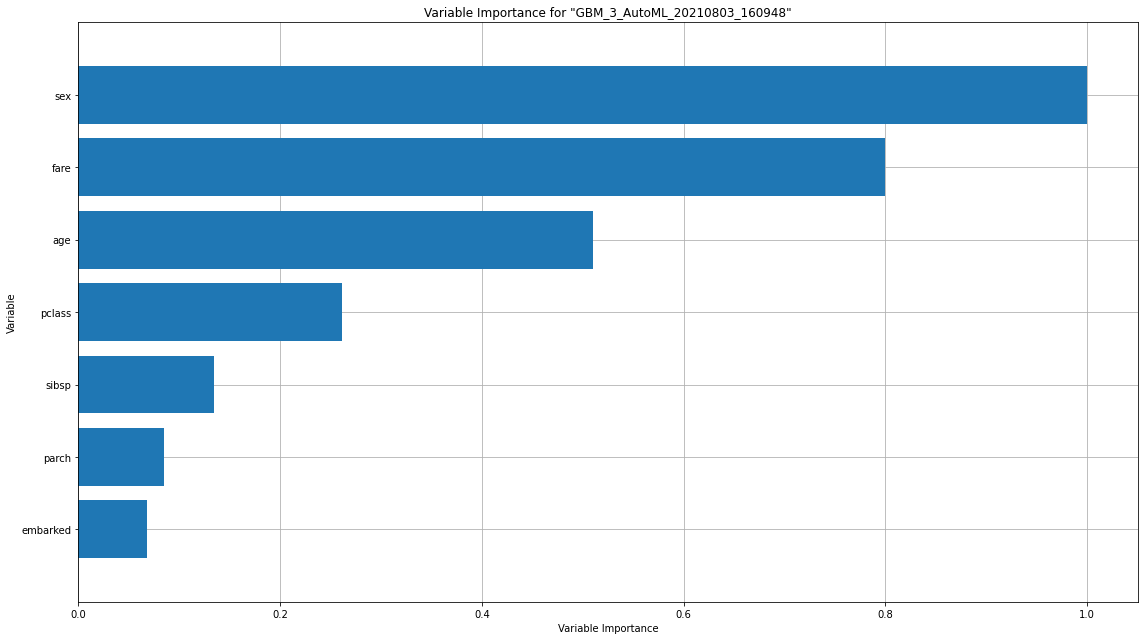

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

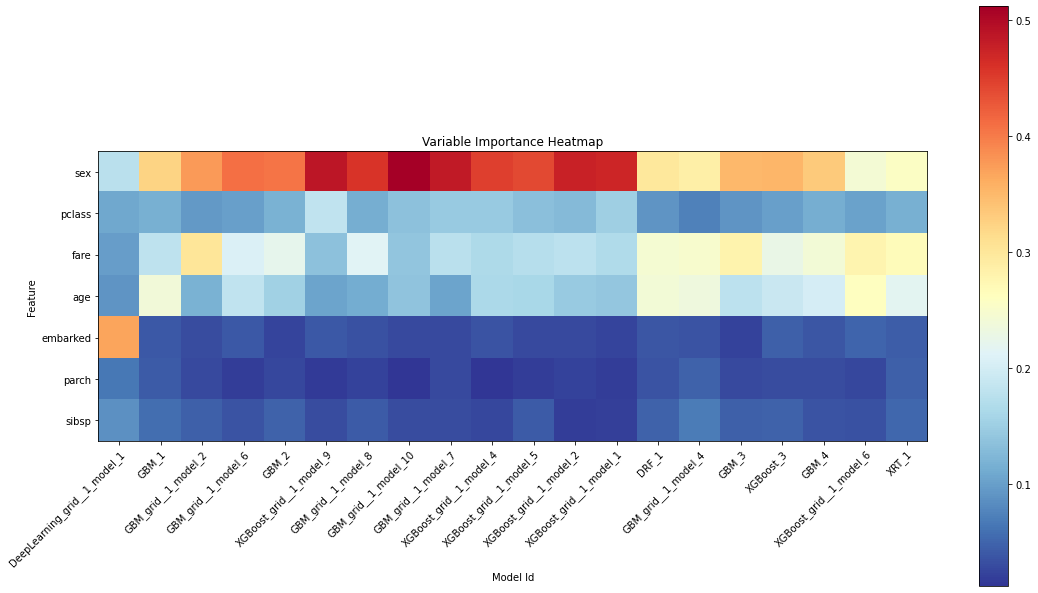

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

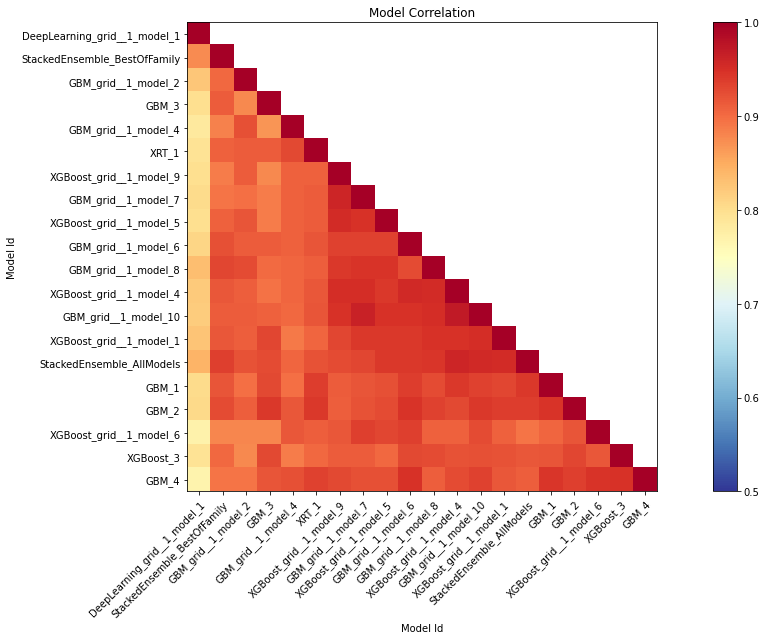

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

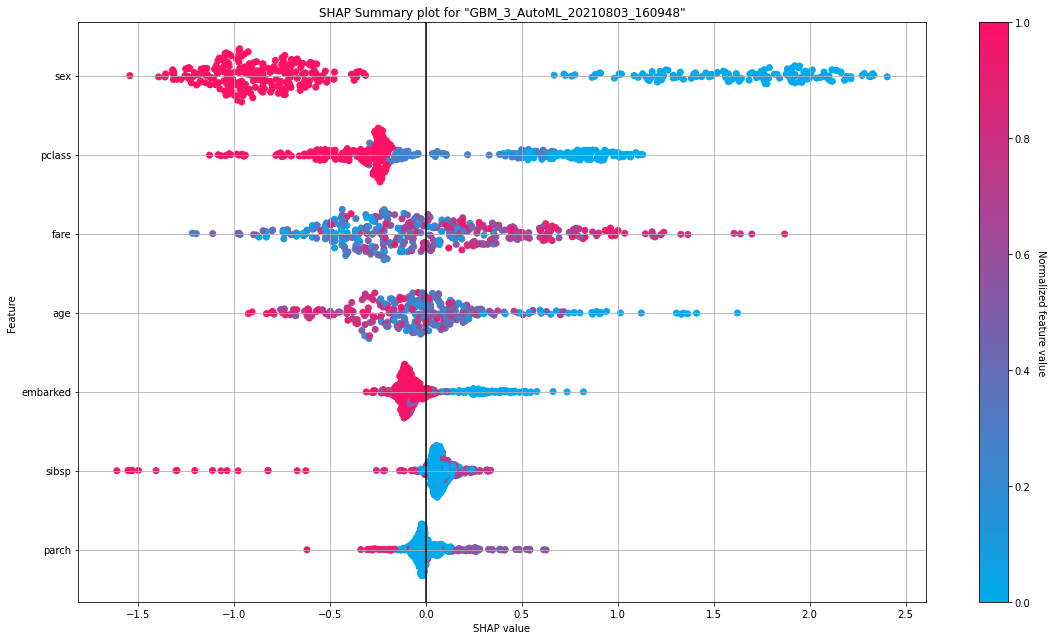

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

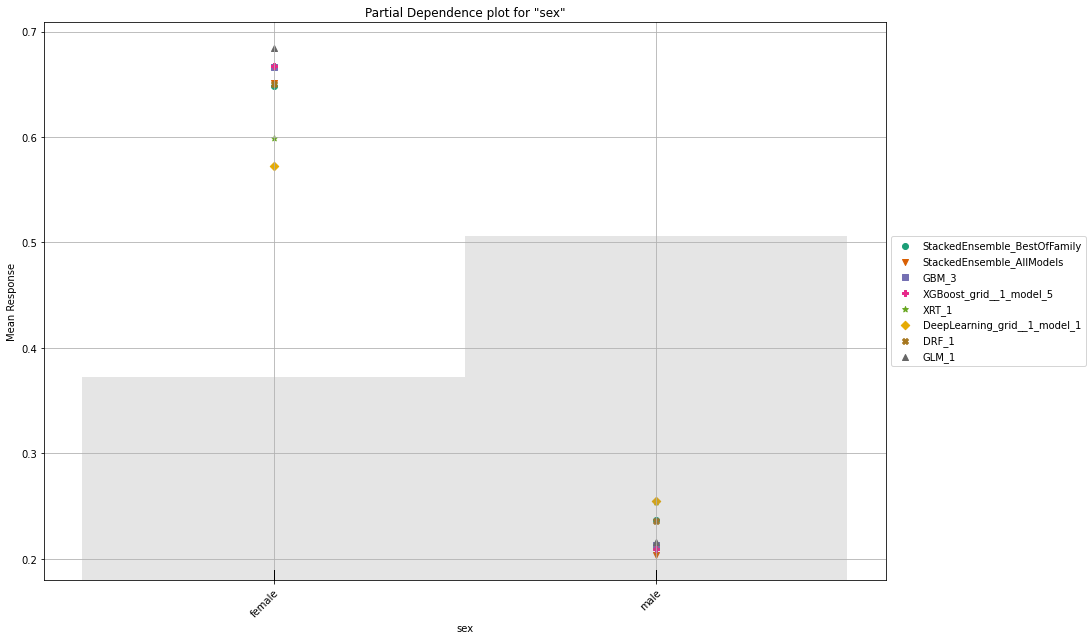

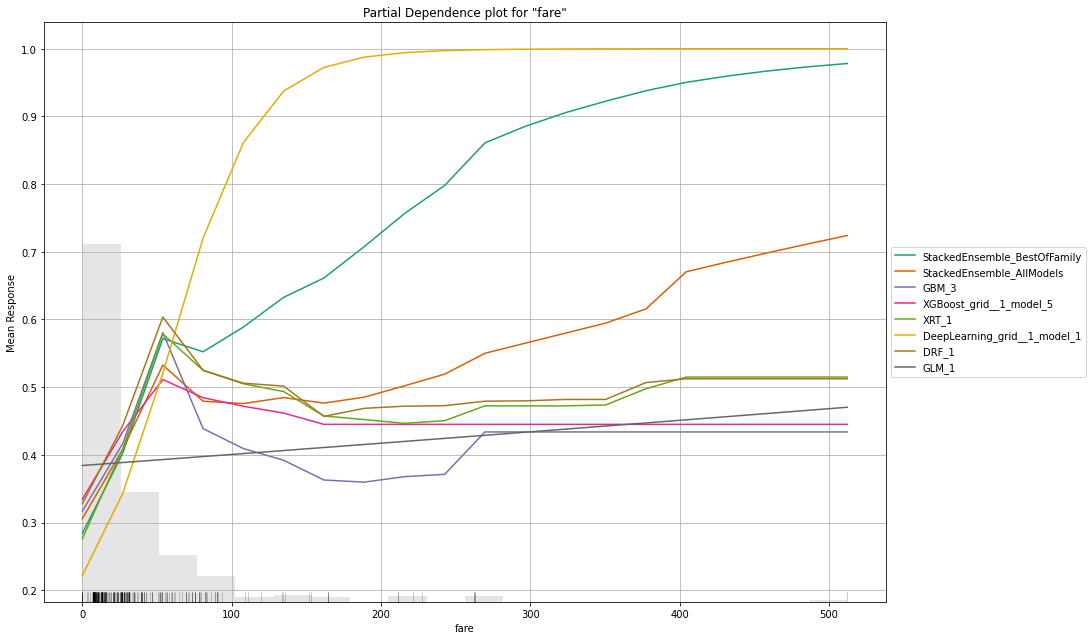

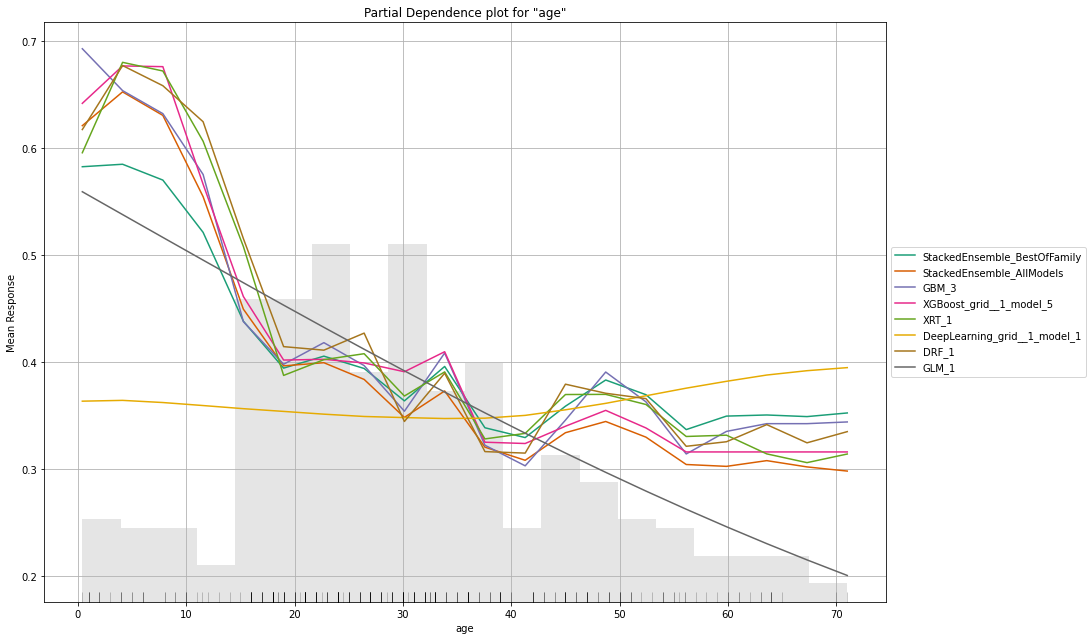

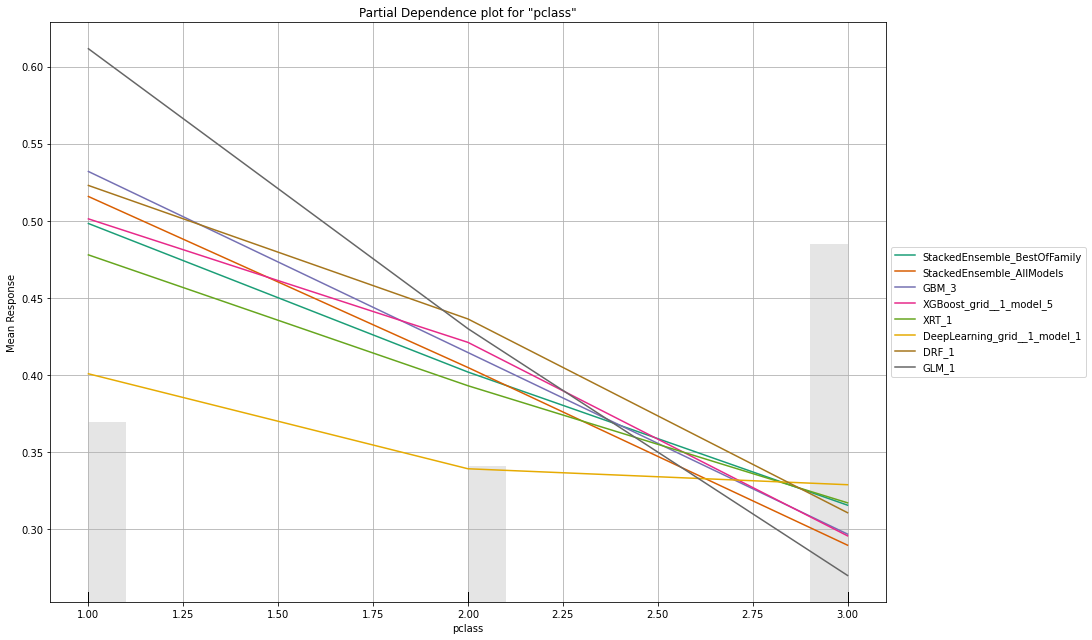

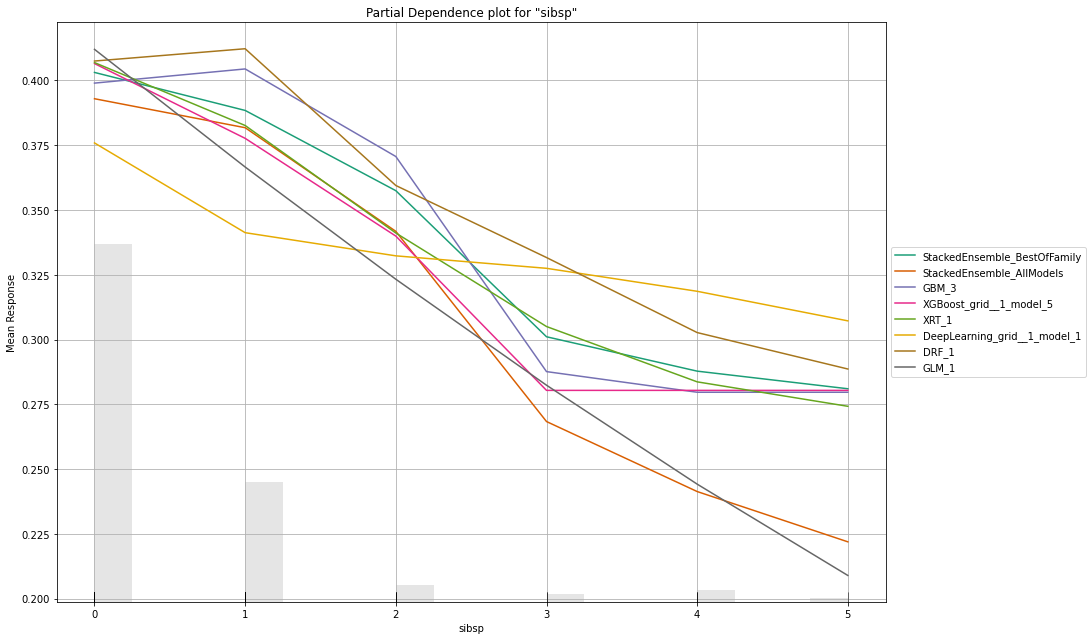

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_BestOfFamily_AutoML_20210803_160948,0.857418,0.437682,0.821717,0.209709,0.372067,0.138434,283,0.077533,StackedEnsemble
StackedEnsemble_AllModels_AutoML_20210803_160948,0.85565,0.439679,0.816659,0.213764,0.373157,0.139246,662,0.179022,StackedEnsemble
GBM_3_AutoML_20210803_160948,0.855535,0.439939,0.819726,0.196589,0.372389,0.138674,211,0.025549,GBM
GBM_grid__1_AutoML_20210803_160948_model_7,0.853434,0.436005,0.823896,0.212716,0.371309,0.13787,211,0.025479,GBM
XGBoost_grid__1_AutoML_20210803_160948_model_5,0.853154,0.443098,0.814359,0.213815,0.374559,0.140294,95,0.009694,XGBoost
GBM_2_AutoML_20210803_160948,0.852849,0.443891,0.808977,0.193407,0.373289,0.139345,157,0.023396,GBM
GBM_grid__1_AutoML_20210803_160948_model_10,0.852462,0.444253,0.814071,0.217542,0.374927,0.140571,216,0.025413,GBM
XRT_1_AutoML_20210803_160948,0.851945,0.449294,0.816544,0.21209,0.378014,0.142894,270,0.031414,DRF
GBM_grid__1_AutoML_20210803_160948_model_6,0.851803,0.445834,0.810386,0.206824,0.37594,0.141331,191,0.024588,GBM
XGBoost_grid__1_AutoML_20210803_160948_model_4,0.85122,0.447464,0.810708,0.218198,0.376826,0.141998,300,0.009191,XGBoost


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_AutoML_20210803_160948


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39905782893997743: 


,,0,1,Error,Rate
0,0,507.0,66.0,0.1152,(66.0/573.0)
1,1,54.0,289.0,0.1574,(54.0/343.0)
2,Total,561.0,355.0,0.131,(120.0/916.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

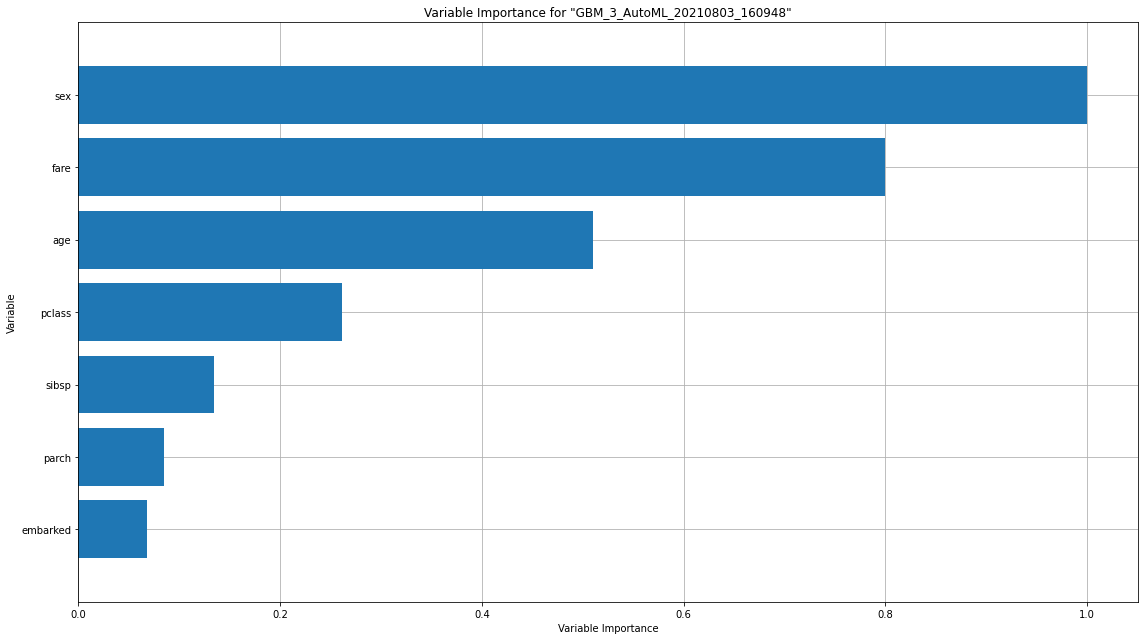

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

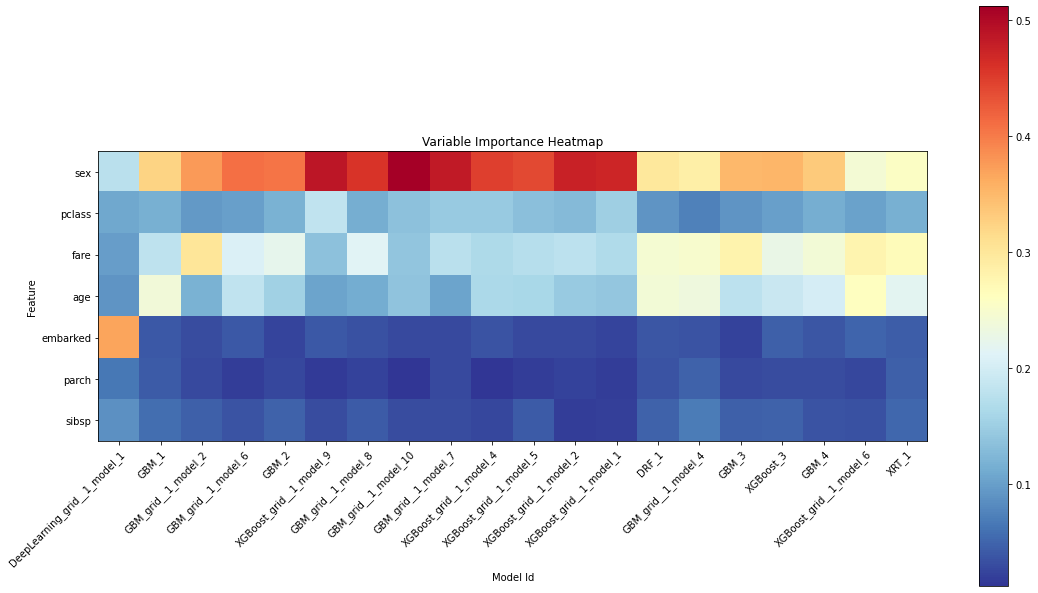

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

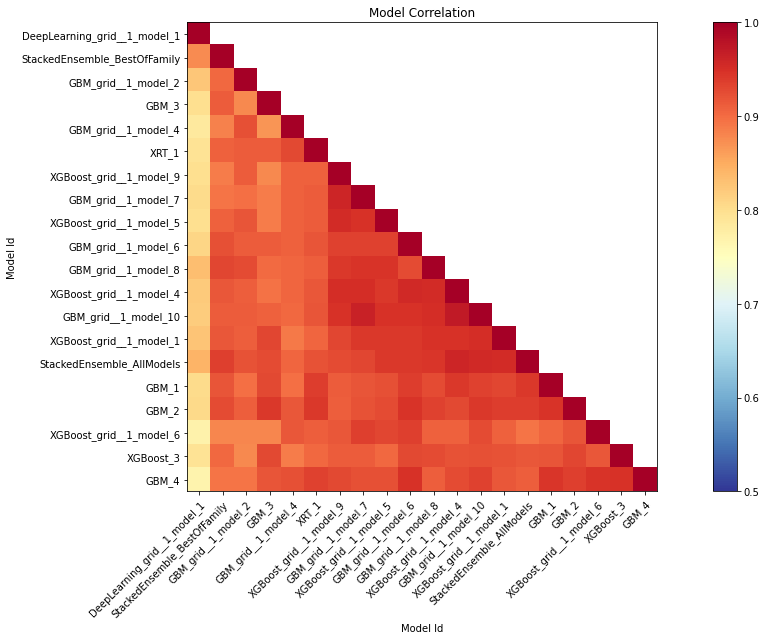

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

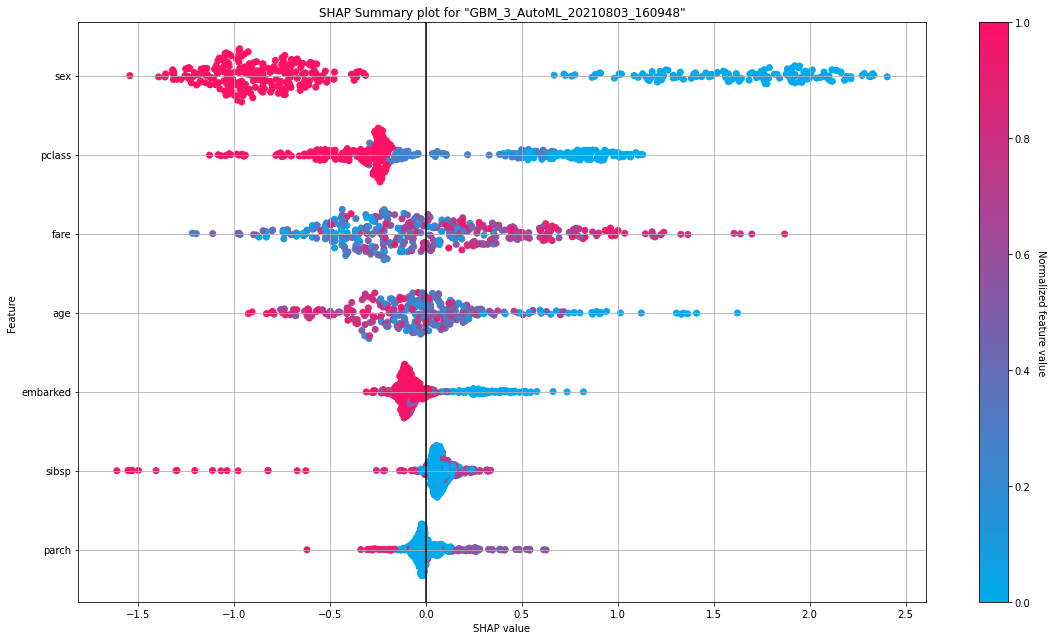

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

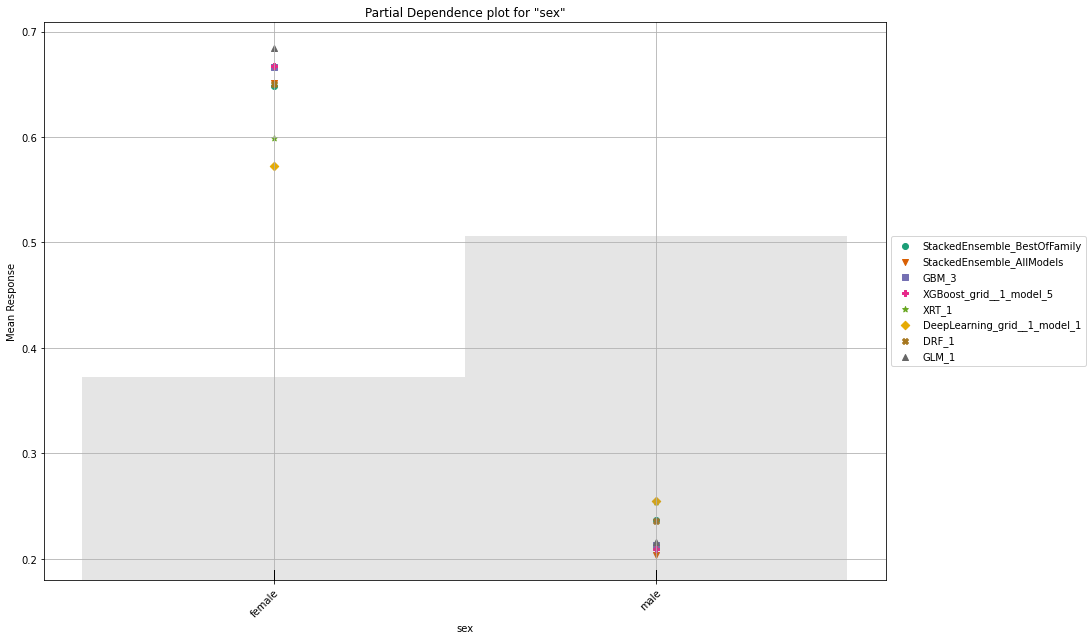

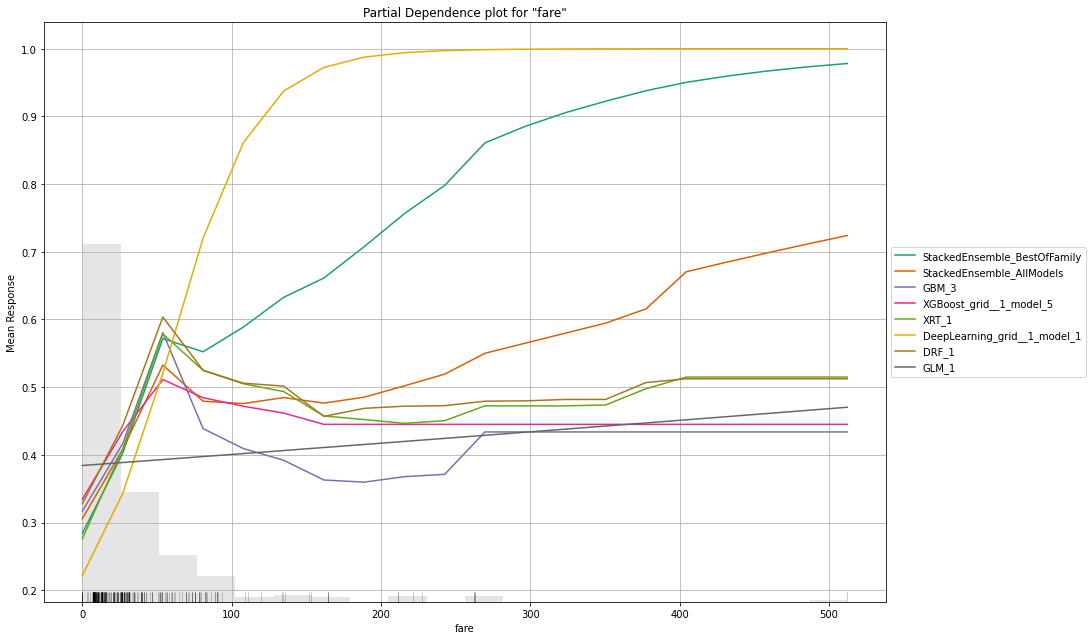

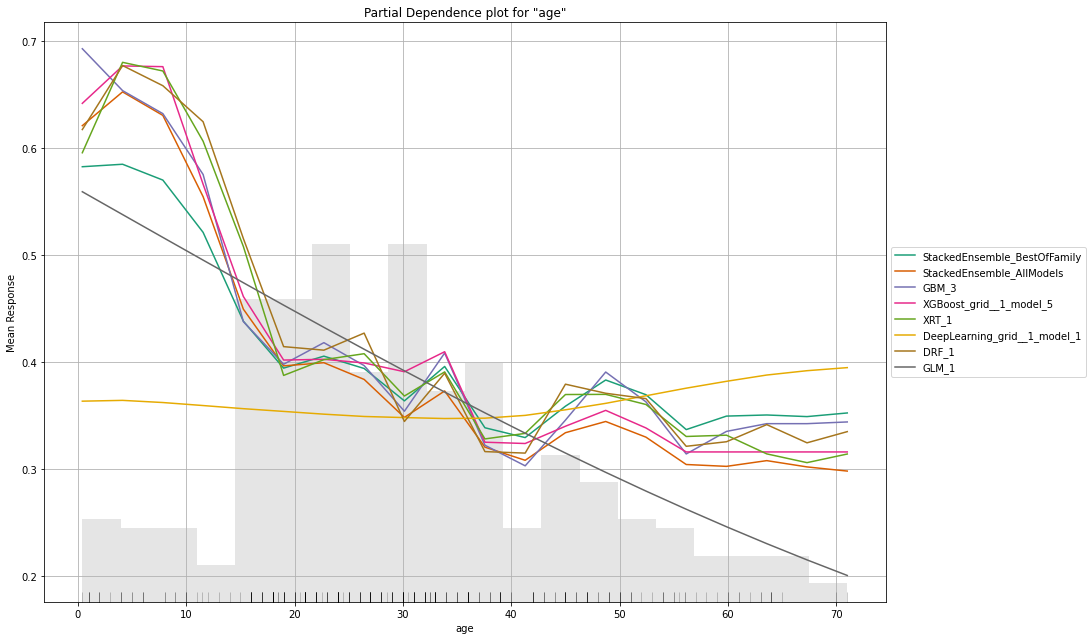

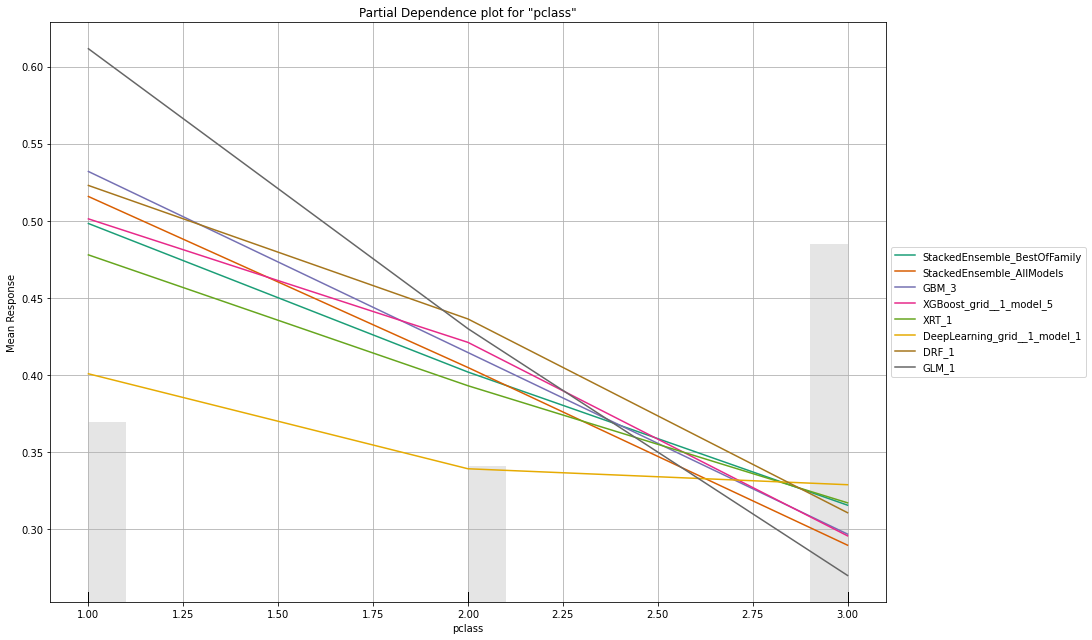

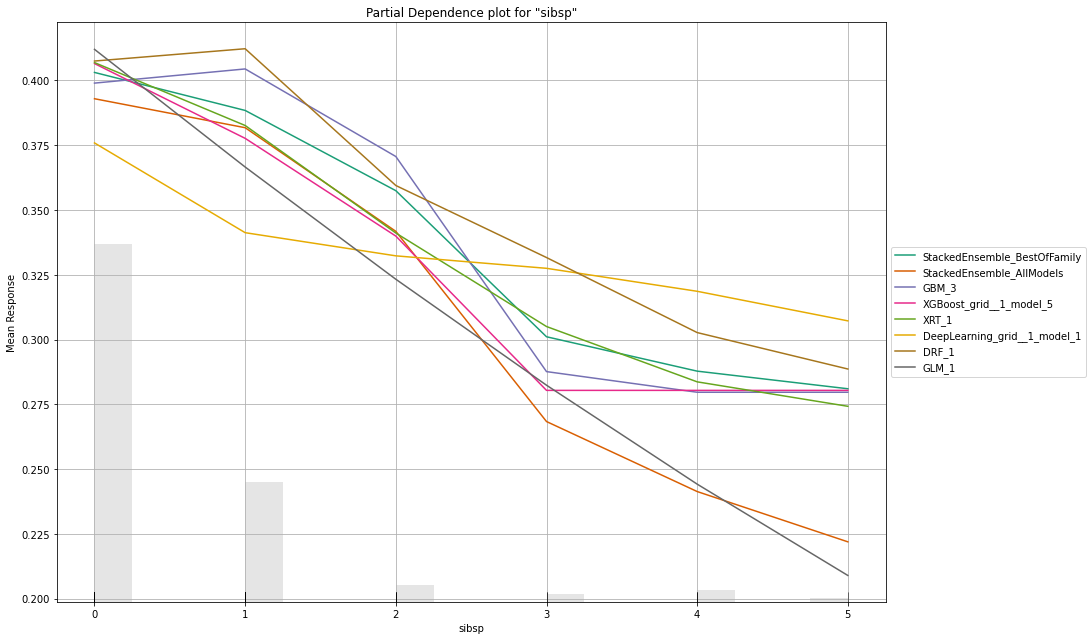

In [ ]:
# https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html#explainability
model.explain(test)